I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wt_z/'

em_method = 'gp'
split_method = 'random'

In [4]:
%%bash
ls -d ~/des/PearceLHC_wt_z/*

/u/ki/swmclau2/des/PearceLHC_wt_z/a_0.81120


In [5]:
a = 0.81120
z = 1.0/a - 1.0


In [6]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [7]:
emu = OriginalRecipe(training_dir, method = em_method, fixed_params=fixed_params, independent_variable='wt')

In [10]:
emu._ordered_params

OrderedDict([('logMmin', (12.5, 13.5)),
             ('sigma_logM', (0.2, 1.0)),
             ('logM0', (10, 13)),
             ('logM1', (13.0, 16.0)),
             ('alpha', (0.7, 1.2)),
             ('f_c', (0.05, 0.5)),
             ('r', (0.047060950000000004, 3.7381838250000001))])

In [9]:
print emu.y

[ 0.01377251  0.00743958 -0.00102926 ..., -0.06406487 -0.06449263
 -0.0649389 ]


In [12]:
params = {}
params['logMmin'] = 13.4
params['sigma_logM'] = 0.1
params['f_c'] = 0.19
params['alpha'] = 1.0
params['logM1'] = 14.0
params['logM0'] = 12.0

[]

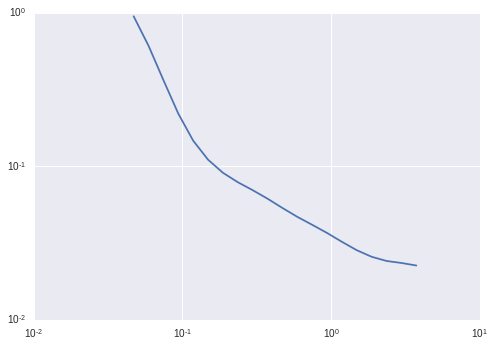

In [17]:
wt = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
plt.plot(emu.scale_bin_centers, wt)
plt.loglog()

In [12]:
from pearce.mocks import compute_prim_haloprop_bins, cat_dict

In [13]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [14]:
cat.load_model(a, 'hsabRedMagic')

In [11]:
binno = 1
params = {pname:val for pname, val in zip(emu._ordered_params.iterkeys(), emu.x[binno*binlen,:-1])}
cat.populate(params)

NameError: name 'binlen' is not defined

wt = cat.calc_wt(theta_bins, do_jackknife=False,n_cores=1)

In [ ]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 20)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [ ]:
fig = plt.figure(figsize=(45,14))


emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.333),
                    ('alpha', 1.053),('logM1', 13.5), ('logMmin', 12.033)]

em_params = dict(emulation_point)

em_params.update(fixed_params)
del em_params['z']

fixed_params2 = {'mean_occupation_satellites_assembias_param1':0.0,
                'mean_occupation_centrals_assembias_param1':0.0,
                'disp_func_slope_satellites':1.0,
                'disp_func_slope_centrals':1.0}

for idx, (param, bounds) in enumerate(emu._ordered_params.iteritems()):
    if param == 'r':
        continue
    wt_vals = []
    new_em_params = {}
    new_em_params.update(em_params)
    new_em_params.update(fixed_params2)
    for v in np.linspace(bounds[0], bounds[1], 6):
        new_em_params[param] = v
        wt_vals.append(emu.emulate_wrt_r(new_em_params, tpoints))
    wt_vals = np.array(wt_vals)
    
    pal = sns.cubehelix_palette(wt_vals.shape[0], start=idx, rot=0.3,\
                            dark=0.0, light=.60,reverse = True)
    #sns.palplot(pal)

    sns.set_palette(pal)

    #sns.set_style("darkgrid", {"axes.facecolor": "0.85"})
    plt.subplot(5,2,idx+1)

    for color, wt, v in zip(pal, wt_vals,np.linspace(bounds[0], bounds[1], 6) ):
        plt.plot(tpoints, 1+wt[0,:], color = color, label = r'%s = %.1f'%(param,v) )
    #plt.loglog()
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ variance by %s'%param)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
plt.show()